# CS5814: Assignment 4

## Problem 3

In problem involves using a DQN to solve the Acrobot OpenAI environment.

Details of the environment can be found here: https://gym.openai.com/envs/Acrobot-v1/

## Imports

In [ ]:
import random
from collections import namedtuple, deque
from itertools import count

import gym
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm


In [ ]:
torch.cuda.empty_cache()
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


## Supporting Functions

In [ ]:
def rand_argmax(b, **kw):
    """ a random tie-breaking argmax"""
    return np.argmax(np.random.random(b.shape) * (b == b.max()), **kw)

In [ ]:
def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0))
    return (cumsum[N:] - cumsum[:-N]) / float(N)

In [ ]:
def plot_moving_average(rewards):

    plt.figure(figsize=(8,6))
    plt.plot(rewards, label="Individual", linewidth=1.5)
    plt.plot(running_mean(rewards, 10), label="Averaged", linewidth=1.5)
    plt.xlabel('Episode')
    plt.ylabel('Episode length')
    plt.legend()
    plt.grid()
    plt.show()

## DQN Supporting Functions

In [ ]:
class ReplayMemory(object):
    # From https://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html
    
    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        """Save a transition"""
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

In [ ]:
def iteration_decay(episode):
    """Simple function to decay epsilon based on episode number"""

    episode_end = 500
    start_rate = 0.9
    min_eps = 0.01
    return max(0.99**episode, min_eps)
    #return max(((-start_rate/episode_end)*episode) + start_rate, min_eps)

In [ ]:
def epsilon_greedy_policy(state, policy_net, epsilon=0.01):
    if np.random.random() < epsilon:
        action = random.randint(0, 2)  # TODO - this should instead sample from the action space
    else:
        action = torch.argmax(policy_net(torch.tensor(state).to(device))).item()
    return action

In [ ]:
def simulation(env, policy_net, episodes=100, eps=0.05):
  # a simulation of number of episodes based on trianed policy to determine performance


  episode_durations = []
  for i_episode in tqdm(range(episodes)):
      # Initialize the environment and state

      state = env.reset()

      for t in count():
          # Select and perform an action
          action = epsilon_greedy_policy(state, policy_net, epsilon=eps)
          new_state, reward, done, info = env.step(action)

          # Exit condition
          if done:
              break

          # Move to the next state
          state = new_state


      # Track duration
      episode_durations.append(t + 1)
      
  print("Average trajectory length: {:.4f}".format(np.average(episode_durations)))


In [ ]:
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))

## DQN

In [ ]:
class DQN(nn.Module):
    def __init__(self, state_dim, hidden_dim, action_dim):
        super(DQN, self).__init__()

        self.state_dim = state_dim
        self.hidden_dim = hidden_dim
        self.action_dim = action_dim

        self.l1 = nn.Linear(self.state_dim, self.hidden_dim)
        self.l2 = nn.Linear(self.hidden_dim, self.action_dim)
        self.act = nn.ReLU()

    def forward(self, x):
        x = x.float()
        x = self.l1(x)
        x = self.act(x)
        x = self.l2(x)

        return x

In [ ]:
def optimize_model():
    # Taken from https://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html

    if len(memory) < batch_size:
        return

    transitions = memory.sample(batch_size)
    batch = Transition(*zip(*transitions))

    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None, batch.next_state)), device=device,
                                  dtype=torch.bool)
    non_final_next_states = torch.stack([s for s in batch.next_state if s is not None])

    state_batch = torch.stack(batch.state)
    action_batch = torch.stack(batch.action)
    reward_batch = torch.stack(batch.reward)

    # Compute Q(s_t, a)
    # These are the actions which would've been taken
    # for each batch state according to policy_net
    state_action_values = policy_net(state_batch.to(device)).gather(1, action_batch.reshape(batch_size, 1).to(device))

    # Compute V(s_{t+1}) for all next states.
    next_state_values = torch.zeros(batch_size, device=device)
    next_state_values[non_final_mask] = target_net(non_final_next_states.to(device)).max(1)[0].detach()
    # Compute the expected Q values
    expected_state_action_values = (next_state_values * gamma) + reward_batch.reshape(batch_size)

    # Compute Huber loss
    criterion = nn.SmoothL1Loss()
    loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))

    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    
    for param in policy_net.parameters():
        param.grad.data.clamp_(-1, 1)
    optimizer.step()

## Training Loop

In [ ]:
env = gym.make('Acrobot-v1')

batch_size = 128
gamma = 0.999
epsilon = 0.1  # TODO - make this decay
target_update = 2  # TODO - what is this?
TARGET_UPDATE = 2
epsilon_override = None # Used to define a constant ep value
epsilon_func = iteration_decay


n_actions = env.action_space.n
n_states = env.observation_space.shape[0]

policy_net = DQN(n_states, 30, n_actions).to(device)
target_net = DQN(n_states, 30, n_actions).to(device)

# Not sure what this is doing (think it is setting the weights to be the same for both nets)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()
policy_net.train()

optimizer = optim.Adam(policy_net.parameters(), lr=0.001)
memory = ReplayMemory(10000)

steps = 0
episode_durations = []

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Episode:0, Steps:500 Epsilon:1.000
Episode:1, Steps:500 Epsilon:0.990
Episode:2, Steps:370 Epsilon:0.980
Episode:3, Steps:500 Epsilon:0.970
Episode:4, Steps:500 Epsilon:0.961
Episode:5, Steps:500 Epsilon:0.951
Episode:6, Steps:500 Epsilon:0.941
Episode:7, Steps:500 Epsilon:0.932
Episode:8, Steps:500 Epsilon:0.923
Episode:9, Steps:500 Epsilon:0.914
Episode:10, Steps:500 Epsilon:0.904
Episode:11, Steps:500 Epsilon:0.895
Episode:12, Steps:500 Epsilon:0.886
Episode:13, Steps:500 Epsilon:0.878
Episode:14, Steps:500 Epsilon:0.869
Episode:15, Steps:500 Epsilon:0.860
Episode:16, Steps:500 Epsilon:0.851
Episode:17, Steps:500 Epsilon:0.843
Episode:18, Steps:500 Epsilon:0.835
Episode:19, Steps:500 Epsilon:0.826
Episode:20, Steps:500 Epsilon:0.818
Episode:21, Steps:500 Epsilon:0.810
Episode:22, Steps:500 Epsilon:0.802
Episode:23, Steps:500 Epsilon:0.794
Episode:24, Steps:500 Epsilon:0.786
Episode:25, Steps:500 Epsilon:0.778
Episode:26, Steps:500 Epsilon:0.770
Episode:27, Steps:400 Epsilon:0.762
Ep

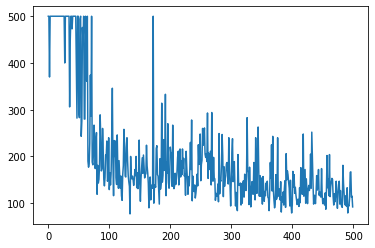

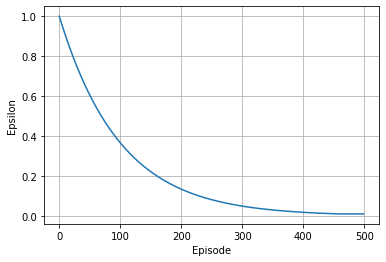

Complete


In [ ]:
# Main training loop

num_episodes = 500
epsilon_array = []
for i_episode in range(num_episodes):
    # Initialize the environment and state

    state = env.reset()

    for t in count():
        # Select and perform an action

        epsilon = epsilon_override if epsilon_override is not None else epsilon_func(i_episode)

        action = epsilon_greedy_policy(state, policy_net, epsilon=epsilon)
        # env.render()
        new_state, reward, done, info = env.step(action)

        reward = torch.tensor([reward], device=device)

        # Observe new state
        if done:
            episode_durations.append(t + 1)
            break

        # Store the transition in memory
        memory.push(torch.tensor(state), torch.tensor(action), torch.tensor(new_state), torch.tensor(reward))

        # Move to the next state
        state = new_state

        # Perform one step of the optimization (on the policy network)
        optimize_model()

        if done:
            episode_durations.append(t + 1)
            break

    # Update the target network, copying all weights and biases in DQN
    if i_episode % TARGET_UPDATE == 0:
        target_net.load_state_dict(policy_net.state_dict())


    epsilon_array.append(epsilon)

    print("Episode:{}, Steps:{} Epsilon:{:.3f}".format(i_episode, t + 1, epsilon))

plt.plot(episode_durations)
plt.show()

# Plotting epsilon decay
plt.plot(epsilon_array)
plt.xlabel('Episode')
plt.ylabel('Epsilon')
plt.grid()
plt.show()

print('Complete')

In [ ]:
simulation(env, policy_net, episodes=100, eps=0.00)

100%|██████████| 100/100 [00:04<00:00, 20.87it/s]

Average trajectory length: 109.6400


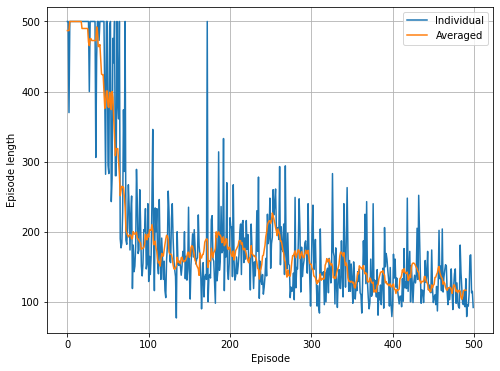

In [ ]:
plot_moving_average(episode_durations)